[Reference](https://python.plainenglish.io/adapting-to-change-the-essential-guide-to-drift-detection-and-management-in-ml-1612618b5039)

# Concept Drift

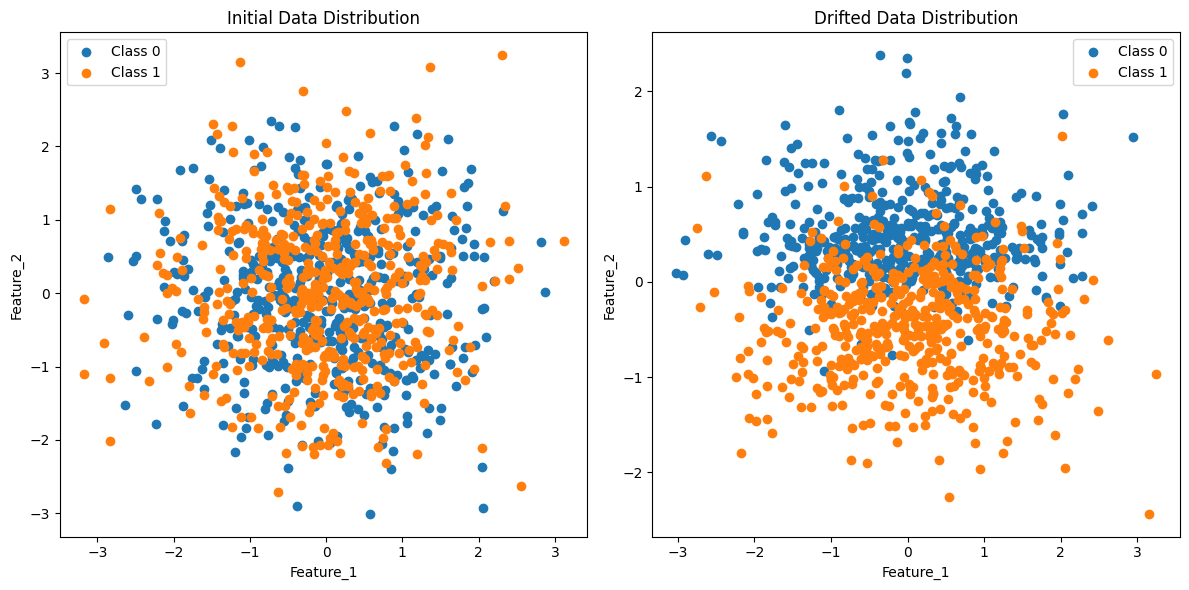

(0.99, 0.542)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generating the initial dataset
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, n_redundant=0,
                           n_classes=2, flip_y=0.01, class_sep=1.5, random_state=42)
df_initial = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(1, 6)])
df_initial['Target'] = y

X_train, X_test, y_train, y_test = train_test_split(df_initial.iloc[:, :-1], df_initial['Target'],
                                                    test_size=0.3, random_state=42)

# Training a model on the initial dataset
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicting and calculating accuracy
y_pred_initial = model.predict(X_test)
accuracy_initial = accuracy_score(y_test, y_pred_initial)

# Generating a new dataset with drift (conceptual drift)
# We'll change the informative features and slightly alter the class separation
X_drifted, y_drifted = make_classification(n_samples=1000, n_features=5, n_informative=2, n_redundant=1,
                                           n_classes=2, flip_y=0.03, class_sep=1.2, random_state=42)

df_drifted = pd.DataFrame(X_drifted, columns=[f'Feature_{i}' for i in range(1, 6)])
df_drifted['Target'] = y_drifted

# Predicting on the new drifted dataset with the old model
y_pred_drifted = model.predict(df_drifted.iloc[:, :-1])
accuracy_drifted = accuracy_score(df_drifted['Target'], y_pred_drifted)

# Plotting the data distributions of initial and drifted datasets
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.title('Initial Data Distribution')
for i in range(2):
    subset = df_initial[df_initial['Target'] == i]
    plt.scatter(subset['Feature_1'], subset['Feature_2'], label=f'Class {i}')
plt.legend()
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')

plt.subplot(1, 2, 2)
plt.title('Drifted Data Distribution')
for i in range(2):
    subset = df_drifted[df_drifted['Target'] == i]
    plt.scatter(subset['Feature_1'], subset['Feature_2'], label=f'Class {i}')
plt.legend()
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')

plt.tight_layout()
plt.show()

(accuracy_initial, accuracy_drifted)

# Sequential Analysis (SPRT)

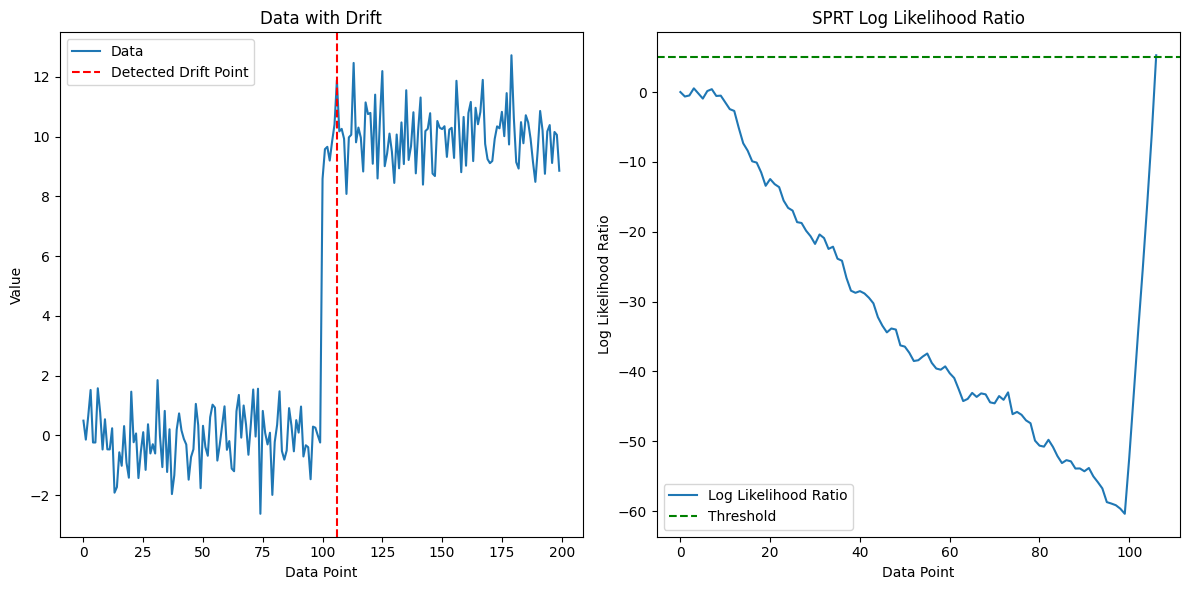

(106, 5.263291456385502)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sprt(data, threshold, mean_h0, mean_h1, std_dev):
    log_likelihood_ratio = 0.0
    llr_values = []
    for i in range(len(data)):
        # Calculate the likelihood ratio
        likelihood_h0 = np.exp(-0.5 * ((data[i] - mean_h0) ** 2) / std_dev**2)
        likelihood_h1 = np.exp(-0.5 * ((data[i] - mean_h1) ** 2) / std_dev**2)
        log_likelihood_ratio += np.log(likelihood_h1 / likelihood_h0)
        llr_values.append(log_likelihood_ratio)

        # Check thresholds
        if log_likelihood_ratio > threshold:
            return i, log_likelihood_ratio, llr_values  # Drift detected

    return None, log_likelihood_ratio, llr_values  # No drift detected

# Generate synthetic data
np.random.seed(42)
data_h0 = np.random.normal(0, 1, 100)  # Data before drift
data_h1 = np.random.normal(10, 1, 100)  # Data after drift
data = np.concatenate([data_h0, data_h1])

# Apply SPRT
drift_point, llr, llr_values = sprt(data, threshold=5, mean_h0=0, mean_h1=1, std_dev=1)

# Visualization
plt.figure(figsize=(12, 6))

# Plot the data
plt.subplot(1, 2, 1)
plt.plot(data, label='Data')
if drift_point is not None:
    plt.axvline(x=drift_point, color='r', linestyle='--', label='Detected Drift Point')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Data with Drift')
plt.legend()

# Plot the log likelihood ratio
plt.subplot(1, 2, 2)
plt.plot(llr_values, label='Log Likelihood Ratio')
plt.axhline(y=5, color='g', linestyle='--', label='Threshold')
plt.xlabel('Data Point')
plt.ylabel('Log Likelihood Ratio')
plt.title('SPRT Log Likelihood Ratio')
plt.legend()

plt.tight_layout()
plt.show()

drift_point, llr

# Statistical Process Control (SPC)

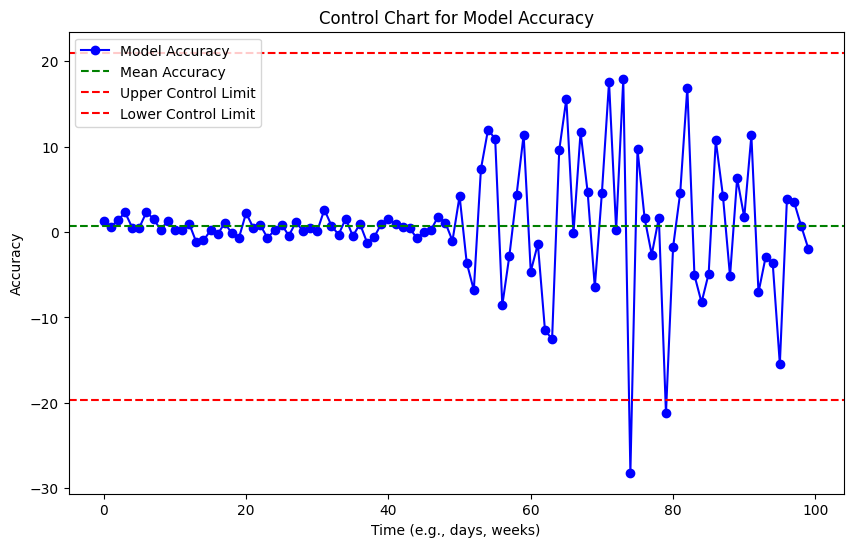

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic accuracy data for a model
np.random.seed(42)
initial_accuracy = np.random.normal(0.75, 1.01, 50)  # Initial model performance
drift_accuracy = np.random.normal(0.65, 11.01, 50)    # Performance after drift
accuracy_data = np.concatenate([initial_accuracy, drift_accuracy])

# Calculate mean and control limits
mean_accuracy = np.mean(accuracy_data)
std_dev_accuracy = np.std(accuracy_data)
upper_control_limit = mean_accuracy + 3 * std_dev_accuracy
lower_control_limit = mean_accuracy - 3 * std_dev_accuracy

# Plotting the control chart
plt.figure(figsize=(10, 6))
plt.plot(accuracy_data, marker='o', linestyle='-', color='b', label='Model Accuracy')
plt.axhline(mean_accuracy, color='green', linestyle='--', label='Mean Accuracy')
plt.axhline(upper_control_limit, color='red', linestyle='--', label='Upper Control Limit')
plt.axhline(lower_control_limit, color='red', linestyle='--', label='Lower Control Limit')
plt.title('Control Chart for Model Accuracy')
plt.xlabel('Time (e.g., days, weeks)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
def plot_psi(expected, actual, buckets=10):
    """Plot the distributions and PSI for each bin."""
    # Break the data into quantiles
    breakpoints = np.linspace(0, 1, buckets + 1)
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)

    # Calculate PSI for each bin
    def sub_psi(e_perc, a_perc):
        """Calculate the PSI for a single bucket."""
        if e_perc == 0:
            e_perc = 0.0001
        if a_perc == 0:
            a_perc = 0.0001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)

    psi_values = np.array([sub_psi(e_perc, a_perc) for e_perc, a_perc in zip(expected_percents, actual_percents)])
    print(f"Population Stability Index (PSI): {np.sum(psi_values):.4f}")
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Distribution plot
    ax1.hist(expected, bins=buckets, alpha=0.5, label='Reference Data')
    ax1.hist(actual, bins=buckets, alpha=0.5, label='Current Data')
    ax1.set_title('Distributions of Reference vs Current Data')
    ax1.set_xlabel('Data Values')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # PSI plot
    ax2.bar(range(buckets), psi_values)
    ax2.set_title('PSI Values by Bin')
    ax2.set_xlabel('Bin')
    ax2.set_ylabel('PSI Value')

    plt.tight_layout()
    plt.show()

plot_psi(reference_data, current_data)

In [6]:
from scipy.stats import ks_2samp
import numpy as np

# Generate two data samples
sample1 = np.random.normal(0, 1, 1000)
sample2 = np.random.normal(0.5, 1, 1000)

# Perform Kolmogorov-Smirnov Test
statistic, p_value = ks_2samp(sample1, sample2)

print(f"K-S Statistic: {statistic}")
print(f"P-value: {p_value}")

K-S Statistic: 0.222
P-value: 5.356249099254043e-22
